In [2]:
# -*- coding: utf-8 -*-
import sys
sys.path.append('/home/jun/SemanticReID')
import torch
from torch import nn, optim
from torch.nn import init
from torchvision import datasets, transforms 
from torchinfo import summary
from torch.nn import functional as F
import matplotlib.pyplot as plt
import matplotlib
import time 
import os
import random
import tqdm.auto as tqdm
from model import * 
from utils.random_erasing import RandomErasing
from utils.dgfolder import DGFolder
import yaml
from shutil import copyfile
from utils.circle_loss import CircleLoss, convert_label_to_similarity
from utils.instance_loss import InstanceLoss
from net.pspnet import PSPNet
from online_triplet_loss.losses import *
import timm
from pathlib import Path
from PIL import Image
import numpy as np
from tqdm.auto import tqdm
proxy = 'http://10.0.0.107:3128'
os.environ['http_proxy'] = proxy 
os.environ['HTTP_PROXY'] = proxy
os.environ['https_proxy'] = proxy
os.environ['HTTPS_PROXY'] = proxy

In [8]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'
#device = 'cpu'

In [4]:
parsing_model = PSPNet(sizes=(1, 2, 3, 6), psp_size=1024, n_classes = 6, deep_features_size=512)
parsing_model.load_state_dict(torch.load('/home/jun/pretrained_models/six_parsing.pth'))

/home/jun/miniconda3/envs/py311/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jun/miniconda3/envs/py311/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [10]:
model = PSPNet(sizes=(1, 2, 3, 6), psp_size=1024, n_classes = 2, deep_features_size=512)
model.load_state_dict(torch.load('/home/jun/pretrained_models/binary_parsing.pth'))
model = model.to(device)

/home/jun/miniconda3/envs/py311/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jun/miniconda3/envs/py311/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
# Import library
from pathlib import Path
# Market1501 dataset dir
raw_data_dir = Path('/home/jun/ReID_Dataset/duke')
# Make dictionary of all image market1501 with keys of image_name and values of image_path
train_list = sorted(list(raw_data_dir.glob('bounding_box_train/*.jpg')))
gallery_list = sorted(list(raw_data_dir.glob('bounding_box_test/*.jpg')))
test_list = sorted(list(raw_data_dir.glob('gallery/*.jpg')))

In [4]:
raw_data_dir = Path('/home/jun/ReID_Dataset/cuhk03_segmentation/dataloader_new_detected/train')

# Make dictionary of all image market1501 with keys of image_name and values of image_path
train_list = sorted(list(raw_data_dir.glob('*/*.png')))


In [6]:
def segmentation_augmentation(img_path, model):
        
    transform = transforms.Compose([
            transforms.Resize(size=(224, 224),interpolation=3), #Image.BICUBIC
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    
    output = {}

    original = Image.open(img_path)
    w = original.size[0] 
    h = original.size[1]
    resize = transforms.Resize((h, w), interpolation=3)
    original_name = img_path.name
    output[img_path] = original
    
    # Transform image for model input
    img = transform(original).unsqueeze(0)
    img = img.to(next(model.parameters()).device)
    
    pred = model(img)
    if len(pred) == 2:
        pred,_ = pred 
    original = np.array(original)
    #output[original_name] = Image.fromarray(img.astype(np.uint8))
    pred = resize(pred) 
    pred = pred.squeeze(dim=0)        
    pred = pred.cpu().detach().numpy().transpose(1, 2, 0)
    pred = np.asarray(np.argmax(pred, axis=2), dtype=np.uint8)
    output[None] = Image.fromarray(pred) 
       
    replace_dict = {0:'foreground', 1:'nohead', 2:'nobody', 3:'noarms', 4:'nolegs', 5:'nofeets'}
    for id, name in replace_dict.items():
        new_img = original.copy()
        new_img[pred == id] = [0.4914, 0.4822, 0.4465]
        new_img_name = original_name.replace(original_name.split('.')[0].split('_')[2],original_name.split('.')[0].split('_')[2] + name) 
        new_img_path = img_path.parent / new_img_name 
        output[new_img_path] = Image.fromarray(new_img.astype(np.uint8))
 
    return output

In [13]:
def part_erasing(img_path, model, propability):
    if random.uniform(0, 1) < propability:
        transform = transforms.Compose([
                transforms.Resize(size=(224, 224),interpolation=3), #Image.BICUBIC
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
        output = {}
        original = Image.open(img_path)
        w = original.size[0] 
        h = original.size[1]
        resize = transforms.Resize((h, w), interpolation=3)
        original_name = img_path.name
        
        # Transform image for model input
        img = transform(original).unsqueeze(0)
        img = img.to(next(model.parameters()).device)
        with torch.inference_mode():
            pred = model(img)
        
        original = np.array(original)
        #output[original_name] = Image.fromarray(img.astype(np.uint8))
        pred = resize(pred) 
        pred = pred.squeeze(dim=0)        
        pred = pred.cpu().detach().numpy().transpose(1, 2, 0)
        pred = np.asarray(np.argmax(pred, axis=2), dtype=np.uint8)
        
        replace_dict = {0:'foreground', 1:'nohead', 2:'nobody', 3:'noarms', 4:'nolegs', 5:'nofeets'}
        random_id = random.randint(0, 6)
        new_img = original.copy()
        new_img[pred == random_id] = [0, 0, 0] 
        new_img = Image.fromarray(new_img.astype(np.uint8)) 
        new_img.save(img_path)
    else:
        return None


In [6]:
def ground_erasing(img_path, model):
    transform = transforms.Compose([
            transforms.Resize(size=(224, 224),interpolation=3), #Image.BICUBIC
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    output = {}
    original = Image.open(img_path)
    w = original.size[0] 
    h = original.size[1]
    resize = transforms.Resize((h, w), interpolation=3)
    original_name = img_path.name
        
    # Transform image for model input
    img = transform(original).unsqueeze(0)
    img = img.to(next(model.parameters()).device)
    with torch.inference_mode():
        pred,_ = model(img)
        
    original = np.array(original)
    #output[original_name] = Image.fromarray(img.astype(np.uint8))
    pred = resize(pred) 
    pred = pred.squeeze(dim=0)        
    pred = pred.cpu().detach().numpy().transpose(1, 2, 0)
    pred = np.asarray(np.argmax(pred, axis=2), dtype=np.uint8)
        
    replace_dict = {0:'foreground', 1:'nohead', 2:'nobody', 3:'noarms', 4:'nolegs', 5:'nofeets'}
    new_img = original.copy()
    new_img[pred == 0] = [0.4914*255, 0.4822*255, 0.4465*255]
    new_img = Image.fromarray(new_img.astype(np.uint8)) 
    #return new_img
    new_img.save(img_path)
def twin_ground_erasing(img_path, model):
    transform = transforms.Compose([
            transforms.Resize(size=(224, 224),interpolation=3), #Image.BICUBIC
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    output = {}
    original = Image.open(img_path)
    w = original.size[0] 
    h = original.size[1]
    resize = transforms.Resize((h, w), interpolation=3)
    original_name = img_path.name
        
    # Transform image for model input
    img = transform(original).unsqueeze(0)
    img = img.to(next(model.parameters()).device)
    with torch.inference_mode():
        pred,_ = model(img)
        
    original = np.array(original)
    #output[original_name] = Image.fromarray(img.astype(np.uint8))
    pred = resize(pred) 
    pred = pred.squeeze(dim=0)        
    pred = pred.cpu().detach().numpy().transpose(1, 2, 0)
    pred = np.asarray(np.argmax(pred, axis=2), dtype=np.uint8)
        
    replace_dict = {0:'foreground', 1:'nohead', 2:'nobody', 3:'noarms', 4:'nolegs', 5:'nofeets'}
    new_img = original.copy()
    new_img[pred == 0] = [0.4914*255, 0.4822*255, 0.4465*255]
    output = np.hstack((original, new_img)) 
    output = Image.fromarray(output.astype(np.uint8)) 
    #return output
    output.save(img_path)
def ground_grayscale(img_path, model):
    transform = transforms.Compose([
            transforms.Resize(size=(224, 224),interpolation=3), #Image.BICUBIC
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    output = {}
    original = Image.open(img_path)
    w = original.size[0] 
    h = original.size[1]
    resize = transforms.Resize((h, w), interpolation=3)
    original_name = img_path.name
        
    # Transform image for model input
    img = transform(original).unsqueeze(0)
    img = img.to(next(model.parameters()).device)
    with torch.inference_mode():
        pred,_ = model(img)
        
    #output[original_name] = Image.fromarray(img.astype(np.uint8))
    pred = resize(pred) 
    pred = pred.squeeze(dim=0)        
    pred = pred.cpu().detach().numpy().transpose(1, 2, 0)
    pred = np.asarray(np.argmax(pred, axis=2), dtype=np.uint8)
        
    replace_dict = {0:'foreground', 1:'nohead', 2:'nobody', 3:'noarms', 4:'nolegs', 5:'nofeets'}
    new_img = np.array(original).copy()
    gray_scale = np.array(original.convert('L')) 
    new_img[pred == 0] = np.stack([gray_scale] * 3, axis=-1)[pred == 0]
    new_img = Image.fromarray(new_img.astype(np.uint8)) 
    #return new_img
    new_img.save(img_path)
def twin_ground_grayscale(img_path, model):
    transform = transforms.Compose([
            transforms.Resize(size=(224, 224),interpolation=3), #Image.BICUBIC
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    output = {}
    original = Image.open(img_path)
    w = original.size[0] 
    h = original.size[1]
    resize = transforms.Resize((h, w), interpolation=3)
    original_name = img_path.name
        
    # Transform image for model input
    img = transform(original).unsqueeze(0)
    img = img.to(next(model.parameters()).device)
    with torch.inference_mode():
        pred,_ = model(img)
        
    #output[original_name] = Image.fromarray(img.astype(np.uint8))
    pred = resize(pred) 
    pred = pred.squeeze(dim=0)        
    pred = pred.cpu().detach().numpy().transpose(1, 2, 0)
    pred = np.asarray(np.argmax(pred, axis=2), dtype=np.uint8)
        
    replace_dict = {0:'foreground', 1:'nohead', 2:'nobody', 3:'noarms', 4:'nolegs', 5:'nofeets'}
    new_img = np.array(original).copy()
    gray_scale = np.array(original.convert('L')) 
    new_img[pred == 0] = np.stack([gray_scale] * 3, axis=-1)[pred == 0]
    output = np.hstack((np.array(original), new_img)) 
    output = Image.fromarray(output.astype(np.uint8)) 
    #return output
    output.save(img_path)

In [36]:

def PICreater(img_path, model):
    transform = transforms.Compose([
            transforms.Resize(size=(224, 224),interpolation=3), #Image.BICUBIC
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    output = {}
    original = Image.open(img_path)
    w = original.size[0] 
    h = original.size[1]
    resize = transforms.Resize((h, w), interpolation=3)
    original_name = img_path.name
        
    # Transform image for model input
    img = transform(original).unsqueeze(0)
    img = img.to(next(model.parameters()).device)
    with torch.inference_mode():
        pred = model(img)
        pred = F.interpolate(input=pred, size=(img.shape[2], img.shape[3]//2), mode='bilinear', align_corners=False) 
    img = F.interpolate(input=img, size=(img.shape[2], img.shape[3]//2), mode='bilinear', align_corners=False)  
    x_parsing = pred
    softmax = torch.nn.Softmax(dim=1)
    x_parsing = softmax(x_parsing) # torch.Size([16, 5, 28, 28])
    # Get all the filter of head, body, arm, leg and feat
    filters = x_parsing[:,1:,:,:]
    # Get the foreground filter by sum up all the filter of head, body, arm, leg and feat
    fg = torch.sum(filters, dim = 1).unsqueeze(1) # torch.Size([32, 1, 224, 224])
    fg = torch.sum(filters, dim = 1).unsqueeze(1) # torch.Size([32, 1, 224, 224])
    img = torch.cat((img,img*fg), dim = 3).cpu()
    
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    denormalize = transforms.Normalize(
    mean=[-m/s for m, s in zip(mean, std)],
    std=[1/s for s in std]
    )
    denorm_tensor = denormalize(img.squeeze()).permute(1, 2, 0).clamp(0, 1).numpy()
    output = Image.fromarray((denorm_tensor * 255).astype('uint8'))
    
    #return output
    output.save(img_path) 
    '''
    original = np.array(original)
    #output[original_name] = Image.fromarray(img.astype(np.uint8))
    pred = resize(pred) 
    pred = pred.squeeze(dim=0)        
    pred = pred.cpu().detach().numpy().transpose(1, 2, 0)
    pred = np.asarray(np.argmax(pred, axis=2), dtype=np.uint8)
        
    replace_dict = {0:'foreground', 1:'nohead', 2:'nobody', 3:'noarms', 4:'nolegs', 5:'nofeets'}
    new_img = original.copy()
    new_img[pred == 0] = [0, 0, 0]
    output = np.hstack((original, new_img)) 
    output = Image.fromarray(output.astype(np.uint8)) 
    #return output
    output.save(img_path)'''

In [31]:
twin_ground_grayscale(train_list[500], model).save('/home/jun/experiment_img/4.jpg')

NameError: name 'twin_ground_grayscale' is not defined

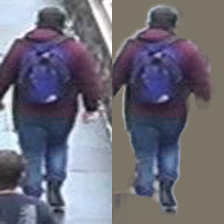

In [35]:
PICreater(train_list[500], model)

/home/jun/miniconda3/envs/py311/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


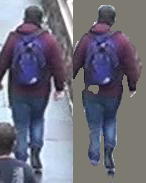

In [10]:
twin_ground_erasing(train_list[500], model)

In [37]:
raw_data_dir = Path('/home/jun/ReID_Dataset/duke_PI')
# Make dictionary of all image market1501 with keys of image_name and values of image_path
train_list = sorted(list(raw_data_dir.glob('bounding_box_train/*.jpg')))
gallery_list = sorted(list(raw_data_dir.glob('bounding_box_test/*.jpg')))
query_list = sorted(list(raw_data_dir.glob('query/*.jpg')))
for path in tqdm(train_list):
    PICreater(path, model)
for path in tqdm(gallery_list):
    PICreater(path, model)
for path in tqdm(query_list):
    PICreater(path, model)

  0%|          | 0/16522 [00:00<?, ?it/s]

  0%|          | 0/17661 [00:00<?, ?it/s]

  0%|          | 0/2228 [00:00<?, ?it/s]

In [42]:
raw_data_dir = Path('/home/jun/ReID_Dataset/market_PI')
# Make dictionary of all image market1501 with keys of image_name and values of image_path
train_list = sorted(list(raw_data_dir.glob('bounding_box_train/*.jpg')))
gallery_list = sorted(list(raw_data_dir.glob('bounding_box_test/*.jpg')))
query_list = sorted(list(raw_data_dir.glob('query/*.jpg')))
for path in tqdm(train_list):
    PICreater(path, model)
for path in tqdm(gallery_list):
    PICreater(path, model)
for path in tqdm(query_list):
    PICreater(path, model)

  0%|          | 0/12936 [00:00<?, ?it/s]

  0%|          | 0/19732 [00:00<?, ?it/s]

  0%|          | 0/3368 [00:00<?, ?it/s]

In [43]:
from pathlib import Path
# Market1501 dataset dir
raw_data_dir = Path('/home/jun/ReID_Dataset/cuhk03_PI')
# Make dictionary of all image market1501 with keys of image_name and values of image_path
pic_list = sorted(list(raw_data_dir.glob('images_detected/*.png')))
for path in tqdm(pic_list):
    PICreater(path, model)

  0%|          | 0/14097 [00:00<?, ?it/s]

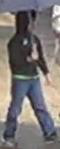

In [10]:
Image.open(train_list[100])

In [12]:
output = segmentation_augmentation(train_list[2], model)
for output_path, output_img in output.items():
    print(output_path)

/home/jun/ReID_Dataset/duke_SinglePic_grayscale_background/bounding_box_train/0001_c2_f0046422.jpg
None
/home/jun/ReID_Dataset/duke_SinglePic_grayscale_background/bounding_box_train/0001_c2_f0046422foreground.jpg
/home/jun/ReID_Dataset/duke_SinglePic_grayscale_background/bounding_box_train/0001_c2_f0046422nohead.jpg
/home/jun/ReID_Dataset/duke_SinglePic_grayscale_background/bounding_box_train/0001_c2_f0046422nobody.jpg
/home/jun/ReID_Dataset/duke_SinglePic_grayscale_background/bounding_box_train/0001_c2_f0046422noarms.jpg
/home/jun/ReID_Dataset/duke_SinglePic_grayscale_background/bounding_box_train/0001_c2_f0046422nolegs.jpg
/home/jun/ReID_Dataset/duke_SinglePic_grayscale_background/bounding_box_train/0001_c2_f0046422nofeets.jpg


/home/jun/miniconda3/envs/py311/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [22]:
for path in tqdm(train_list):
    outputs = segmentation_augmentation(path, model)
    for output_path, output_img in outputs.items(): 
        if output_path != None:
            output_img.save(output_path)

  0%|          | 0/16522 [00:00<?, ?it/s]

AttributeError: 'numpy.ndarray' object has no attribute 'save'

In [19]:
# Turn background to grayscale
# Import library
from pathlib import Path
# Market1501 dataset dir
'''
raw_data_dir = Path('/home/jun/ReID_Dataset/duke_SinglePic_grayscale_background')
# Make dictionary of all image market1501 with keys of image_name and values of image_path
train_list = sorted(list(raw_data_dir.glob('bounding_box_train/*.jpg')))
gallery_list = sorted(list(raw_data_dir.glob('bounding_box_test/*.jpg')))
query_list = sorted(list(raw_data_dir.glob('query/*.jpg')))
for path in tqdm(train_list):
    ground_grayscale(path, model)
for path in tqdm(gallery_list):
    ground_grayscale(path, model)
for path in tqdm(query_list):
    ground_grayscale(path, model)
    

    
# Turn background to grayscale
# Import library
from pathlib import Path
# Market1501 dataset dir
raw_data_dir = Path('/home/jun/ReID_Dataset/duke_TwinPic_grayscale_background')
# Make dictionary of all image market1501 with keys of image_name and values of image_path
train_list = sorted(list(raw_data_dir.glob('bounding_box_train/*.jpg')))
gallery_list = sorted(list(raw_data_dir.glob('bounding_box_test/*.jpg')))
query_list = sorted(list(raw_data_dir.glob('query/*.jpg')))
for path in tqdm(train_list):
    twin_ground_grayscale(path, model)
for path in tqdm(gallery_list):
    twin_ground_grayscale(path, model)
for path in tqdm(query_list):
    twin_ground_grayscale(path, model) 
    
# Turn background to grayscale
# Import library
from pathlib import Path
# Market1501 dataset dir
raw_data_dir = Path('/home/jun/ReID_Dataset/duke_TwinPic_delete_background')
# Make dictionary of all image market1501 with keys of image_name and values of image_path
train_list = sorted(list(raw_data_dir.glob('bounding_box_train/*.jpg')))
gallery_list = sorted(list(raw_data_dir.glob('bounding_box_test/*.jpg')))
query_list = sorted(list(raw_data_dir.glob('query/*.jpg')))
for path in tqdm(train_list):
    twin_ground_erasing(path, model)
for path in tqdm(gallery_list):
    twin_ground_erasing(path, model)
for path in tqdm(query_list):
    twin_ground_erasing(path, model)
'''


raw_data_dir = Path('/home/jun/ReID_Dataset/duke_SinglePic_delete_background')
# Make dictionary of all image market1501 with keys of image_name and values of image_path
train_list = sorted(list(raw_data_dir.glob('bounding_box_train/*.jpg')))
gallery_list = sorted(list(raw_data_dir.glob('bounding_box_test/*.jpg')))
query_list = sorted(list(raw_data_dir.glob('query/*.jpg')))
for path in tqdm(train_list):
    ground_erasing(path, model)
for path in tqdm(gallery_list):
    ground_erasing(path, model)
for path in tqdm(query_list):
    ground_erasing(path, model)

  0%|          | 0/16522 [00:00<?, ?it/s]

  0%|          | 0/17661 [00:00<?, ?it/s]

  0%|          | 0/2228 [00:00<?, ?it/s]

In [18]:
'''
# Turn background to grayscale
# Import library
from pathlib import Path
# Market1501 dataset dir
raw_data_dir = Path('/home/jun/ReID_Dataset/market_SinglePic_grayscale_background')
# Make dictionary of all image market1501 with keys of image_name and values of image_path
train_list = sorted(list(raw_data_dir.glob('bounding_box_train/*.jpg')))
gallery_list = sorted(list(raw_data_dir.glob('bounding_box_test/*.jpg')))
query_list = sorted(list(raw_data_dir.glob('query/*.jpg')))
for path in tqdm(train_list):
    ground_grayscale(path, model)
for path in tqdm(gallery_list):
    ground_grayscale(path, model)
for path in tqdm(query_list):
    ground_grayscale(path, model)
    
raw_data_dir = Path('/home/jun/ReID_Dataset/market_SinglePic_delete_background')
# Make dictionary of all image market1501 with keys of image_name and values of image_path
train_list = sorted(list(raw_data_dir.glob('bounding_box_train/*.jpg')))
gallery_list = sorted(list(raw_data_dir.glob('bounding_box_test/*.jpg')))
query_list = sorted(list(raw_data_dir.glob('query/*.jpg')))
for path in tqdm(train_list):
    ground_erasing(path, model)
for path in tqdm(gallery_list):
    ground_erasing(path, model)
for path in tqdm(query_list):
    ground_erasing(path, model)
    
# Turn background to grayscale
# Import library
from pathlib import Path
# Market1501 dataset dir
raw_data_dir = Path('/home/jun/ReID_Dataset/market_TwinPic_grayscale_background')
# Make dictionary of all image market1501 with keys of image_name and values of image_path
train_list = sorted(list(raw_data_dir.glob('bounding_box_train/*.jpg')))
gallery_list = sorted(list(raw_data_dir.glob('bounding_box_test/*.jpg')))
query_list = sorted(list(raw_data_dir.glob('query/*.jpg')))
for path in tqdm(train_list):
    twin_ground_grayscale(path, model)
for path in tqdm(gallery_list):
    twin_ground_grayscale(path, model)
for path in tqdm(query_list):
    twin_ground_grayscale(path, model)

# Turn background to grayscale
# Import library
from pathlib import Path
# Market1501 dataset dir
raw_data_dir = Path('/home/jun/ReID_Dataset/market_TwinPic_delete_background')
# Make dictionary of all image market1501 with keys of image_name and values of image_path
train_list = sorted(list(raw_data_dir.glob('bounding_box_train/*.jpg')))
gallery_list = sorted(list(raw_data_dir.glob('bounding_box_test/*.jpg')))
query_list = sorted(list(raw_data_dir.glob('query/*.jpg')))
for path in tqdm(train_list):
    twin_ground_erasing(path, model)
for path in tqdm(gallery_list):
    twin_ground_erasing(path, model)
for path in tqdm(query_list):
    twin_ground_erasing(path, model)
'''

raw_data_dir = Path('/home/jun/ReID_Dataset/market_SinglePic_delete_background')
# Make dictionary of all image market1501 with keys of image_name and values of image_path
train_list = sorted(list(raw_data_dir.glob('bounding_box_train/*.jpg')))
gallery_list = sorted(list(raw_data_dir.glob('bounding_box_test/*.jpg')))
query_list = sorted(list(raw_data_dir.glob('query/*.jpg')))
for path in tqdm(train_list):
    ground_erasing(path, model)
for path in tqdm(gallery_list):
    ground_erasing(path, model)
for path in tqdm(query_list):
    ground_erasing(path, model)


  0%|          | 0/12936 [00:00<?, ?it/s]

  0%|          | 0/19732 [00:00<?, ?it/s]

  0%|          | 0/3368 [00:00<?, ?it/s]

In [17]:
'''
# Turn background to grayscale
# Import library
from pathlib import Path
# Market1501 dataset dir
raw_data_dir = Path('/home/jun/ReID_Dataset/cuhk03_SinglePic_grayscale_background')
# Make dictionary of all image market1501 with keys of image_name and values of image_path
pic_list = sorted(list(raw_data_dir.glob('images_detected/*.png')))
for path in tqdm(pic_list):
    ground_grayscale(path, model)

from pathlib import Path
# Market1501 dataset dir
raw_data_dir = Path('/home/jun/ReID_Dataset/cuhk03_SinglePic_delete_background')
# Make dictionary of all image market1501 with keys of image_name and values of image_path
pic_list = sorted(list(raw_data_dir.glob('images_detected/*.png')))
for path in tqdm(pic_list):
    ground_erasing(path, model)

from pathlib import Path
# Market1501 dataset dir
raw_data_dir = Path('/home/jun/ReID_Dataset/cuhk03_TwinPic_grayscale_background')
# Make dictionary of all image market1501 with keys of image_name and values of image_path
pic_list = sorted(list(raw_data_dir.glob('images_detected/*.png')))
for path in tqdm(pic_list):
    twin_ground_grayscale(path, model)

from pathlib import Path
# Market1501 dataset dir
raw_data_dir = Path('/home/jun/ReID_Dataset/cuhk03_TwinPic_delete_background')
# Make dictionary of all image market1501 with keys of image_name and values of image_path
pic_list = sorted(list(raw_data_dir.glob('images_detected/*.png')))
for path in tqdm(pic_list):
    twin_ground_erasing(path, model)
'''
from pathlib import Path
# Market1501 dataset dir
raw_data_dir = Path('/home/jun/ReID_Dataset/cuhk03_SinglePic_delete_background')
# Make dictionary of all image market1501 with keys of image_name and values of image_path
pic_list = sorted(list(raw_data_dir.glob('images_detected/*.png')))
for path in tqdm(pic_list):
    ground_erasing(path, model)

  0%|          | 0/14097 [00:00<?, ?it/s]

/home/jun/miniconda3/envs/py311/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


/home/jun/miniconda3/envs/py311/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


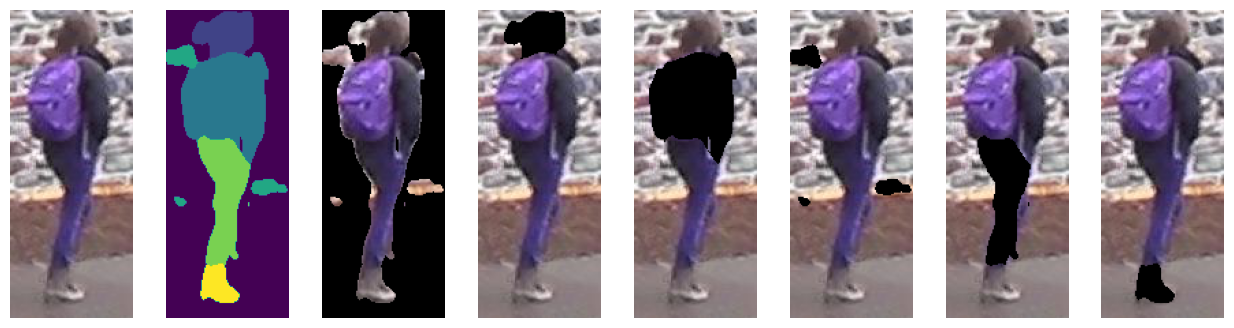

In [10]:
output = segmentation_augmentation(train_list[300], model)
visualize = []
for value in output.values():
    visualize.append(value)
nrows = 1
ncols = len(visualize)
fig = plt.figure(figsize=(2*ncols, 4*nrows))
plt.subplots_adjust(wspace=0.05, hspace=0.05)
for row in range(nrows):
    for col in range(ncols):
        position = row * ncols + col + 1
        ax = plt.subplot(nrows, ncols, position)
        ax.imshow(visualize[col])
        ax.axis(False)